In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import time
import scipy
import sklearn
import copy
import pickle

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef

In [3]:
types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

## Read PreLect features (top50 features)

In [4]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/feature_selection')

features_dict_top50 = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        # sort by tendency and then by weight
        feature_df['abs_weight'] = feature_df['Weight'].abs()
        feature_df = feature_df.sort_values(by=['Tendency', 'abs_weight'], ascending=[False, False])
        feature_df.drop(columns=['abs_weight'], inplace=True)
        features_dict_top50[celltype] = feature_df.head(50)
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [5]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict_top50.keys():
    feature_df = features_dict_top50[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

Feature_count  Positive_feature_count
B                   11                       6
CD4_T               50                      50
CD8_T               22                       7
DC                  32                      15
Mono                19                      10
NK                  33                      17
other                4                       2
other_T             50                      25

In [33]:
features_dict_top50['B']

Gene    Weight  Tendency
10    CD79A  1.484380         1
6     MS4A1  1.270126         1
1      IGKC  0.267143         1
3   HLA-DRA  0.139131         1
2      CD74  0.134287         1
8      IGHM  0.069343         1
5    TMSB4X -0.437352         0
9       B2M -0.279397         0
7    MALAT1 -0.184767         0
4      ACTB -0.115352         0
0    S100A4 -0.115286         0

## Read Zheng dataset

In [6]:
# Read Zheng query dataset
query_adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
query_adata.shape

(68579, 32738)

In [7]:
# change Zheng query dataset var index from ensemble to gene symbol
query_adata_sym = copy.deepcopy(query_adata)
query_adata_sym.var['ensembl'] = query_adata_sym.var.index.tolist()
query_adata_sym.var.index = query_adata_sym.var['gene_symbols'].tolist()
query_adata_sym.var_names_make_unique()
query_adata_sym.var.head()

gene_symbols          ensembl
MIR1302-10      MIR1302-10  ENSG00000243485
FAM138A            FAM138A  ENSG00000237613
OR4F5                OR4F5  ENSG00000186092
RP11-34P13.7  RP11-34P13.7  ENSG00000238009
RP11-34P13.8  RP11-34P13.8  ENSG00000239945

## Make prediction and get likelihood

In [10]:
def predict_celltype_w_symbol(LR_model, query_adata, features_dict, celltype):
    # PreLect features (symbol)
    train_genes = features_dict[celltype]['Gene'].tolist()
    print('Train genes (top10):', train_genes[:10])

    # PreLect features (symbol) have 9 intersectoin with Zheng (symbol)
    query_genes = query_adata.var_names.tolist()
    common_genes = list(set(train_genes) & set(query_genes))
    print('No. common genes:', len(common_genes))
    print('Common genes (top10):', common_genes[:10])

    # Create a full matrix for query data, initializing with zeros for missing genes
    X_query_full = np.zeros((query_adata.shape[0], len(train_genes)))
    # Fill in the values for the common genes
    for i, gene in enumerate(train_genes):
        if gene in common_genes:
            X_query_full[:, i] = query_adata[:, gene].X.toarray().flatten()

    # predict on query dataset
    y_query_pred = LR_model.predict(X_query_full)
    print('Prediction = 1:', sum(y_query_pred == 1))  # predict celltype 的有幾個

    # Get the probability of individual cell predicting as the positive class
    y_query_prob = LR_model.predict_proba(X_query_full)[:, 1]  # Probability for the positive class (class 1)
    print('Probability > 0.5:', sum(y_query_prob > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return y_query_pred, y_query_prob

In [12]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/LR_classifiers/top50')

celltype = 'B'
with open(f'LR_{celltype}_Harmony_l1_top50.pkl', 'rb') as f:
    model_data_B = pickle.load(f)
    lr_B = model_data_B['model']
    feature_names_B = model_data_B['feature_names']

print(feature_names_B[:10])
y_pred_B, y_prob_B = predict_celltype_w_symbol(lr_B, query_adata_sym, features_dict_top50, celltype)

['CD79A', 'MS4A1', 'IGKC', 'HLA-DRA', 'CD74', 'IGHM', 'TMSB4X', 'B2M', 'MALAT1', 'ACTB']
Train genes (top10): ['CD79A', 'MS4A1', 'IGKC', 'HLA-DRA', 'CD74', 'IGHM', 'TMSB4X', 'B2M', 'MALAT1', 'ACTB']
No. common genes: 9
Common genes (top10): ['CD74', 'ACTB', 'CD79A', 'HLA-DRA', 'TMSB4X', 'B2M', 'MS4A1', 'MALAT1', 'S100A4']
Prediction = 1: 610
Probability > 0.5: 610


In [14]:
prediction_dict = {}
likelihood_dict = {}

for celltype in types:
    print(celltype, '=====================')
    with open(f'LR_{celltype}_Harmony_l1_top50.pkl', 'rb') as f:
            model_data = pickle.load(f)
            lr_celltype = model_data['model']
            feature_names = model_data['feature_names']
    
    print('Feature names:', feature_names[:10])
    y_pred_celltype, y_prob_celltype = predict_celltype_w_symbol(lr_celltype, query_adata_sym, features_dict_top50, celltype)
    prediction_dict[celltype] = y_pred_celltype
    likelihood_dict[celltype] = y_prob_celltype

B =====================
Feature names: ['CD79A', 'MS4A1', 'IGKC', 'HLA-DRA', 'CD74', 'IGHM', 'TMSB4X', 'B2M', 'MALAT1', 'ACTB']
Train genes (top10): ['CD79A', 'MS4A1', 'IGKC', 'HLA-DRA', 'CD74', 'IGHM', 'TMSB4X', 'B2M', 'MALAT1', 'ACTB']
No. common genes: 9
Common genes (top10): ['CD74', 'ACTB', 'CD79A', 'HLA-DRA', 'TMSB4X', 'B2M', 'MS4A1', 'MALAT1', 'S100A4']
Prediction = 1: 610
Probability > 0.5: 610
CD4_T =====================
Feature names: ['CD4', 'CD40LG', 'TRAT1', 'TOMM7', 'ITM2A', 'RNASET2', 'CD52', 'CD2', 'TRBC1', 'TMSB10']
Train genes (top10): ['CD4', 'CD40LG', 'TRAT1', 'TOMM7', 'ITM2A', 'RNASET2', 'CD52', 'CD2', 'TRBC1', 'TMSB10']
No. common genes: 45
Common genes (top10): ['CORO1B', 'TSHZ2', 'RORA', 'IL6ST', 'GAPDH', 'EML4', 'TRAT1', 'SYNE2', 'SMCHD1', 'LIMS1']
Prediction = 1: 51834
Probability > 0.5: 51834
CD8_T =====================
Feature names: ['CD8B', 'CD8A', 'CD3D', 'TRAC', 'CD3G', 'CD3E', 'CCL5', 'FTH1', 'H3F3B', 'PTMA']
Train genes (top10): ['CD8B', 'CD8A', 'CD3D'

In [15]:
prediction_df = pd.DataFrame(prediction_dict)
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

B     CD4_T     CD8_T            DC          Mono            NK  \
0  1.055932e-19  1.000000  0.953149  1.025037e-19  2.383494e-10  1.101509e-13   
1  1.922833e-33  0.999689  0.998860  7.930619e-30  1.298092e-11  9.833114e-22   
2  3.740313e-36  1.000000  0.000458  7.263669e-36  9.195744e-13  5.463452e-32   
3  9.993695e-01  1.000000  0.003460  1.613095e-02  1.142677e-08  3.982728e-09   
4  7.041269e-28  1.000000  0.981772  1.183579e-17  9.094504e-08  6.331480e-12   

          other       other_T  
0  3.695499e-21  1.081192e-03  
1  4.044491e-31  5.129632e-08  
2  9.730696e-29  3.547924e-16  
3  1.492544e-11  9.780305e-05  
4  1.038114e-16  2.017316e-03

In [34]:
prediction_df.head()

B  CD4_T  CD8_T  DC  Mono  NK  other  other_T
0  0      1      1   0     0   0      0        0
1  0      1      1   0     0   0      0        0
2  0      1      0   0     0   0      0        0
3  1      1      0   0     0   0      0        0
4  0      1      1   0     0   0      0        0

In [31]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Zheng/Predict_w_Hao_LR')

prediction_df.to_csv('predict_w_Hao_PreLect_top50_predictions.csv')
likelihood_df.to_csv('predict_w_Hao_PreLect_top50_likelihood.csv')

In [18]:
prediction_df.sum(axis=0)

B            610
CD4_T      51834
CD8_T      32692
DC          3100
Mono        2026
NK           638
other        402
other_T     1964
dtype: int64

In [19]:
query_adata_sym.obs['celltype'].value_counts()

celltype
CD8+ Cytotoxic T                20773
CD8+/CD45RA+ Naive Cytotoxic    16666
CD56+ NK                         8776
CD4+/CD25 T Reg                  6187
CD19+ B                          5908
CD4+/CD45RO+ Memory              3061
CD14+ Monocyte                   2862
Dendritic                        2099
CD4+/CD45RA+/CD25- Naive T       1873
CD34+                             277
CD4+ T Helper2                     97
Name: count, dtype: int64

## Plot likelihood on UMAP

In [20]:
# Concatenate the likelihood_df with the adata.obs
likelihood_df.index = query_adata_sym.obs_names
query_adata_sym.obs = pd.concat([query_adata_sym.obs, likelihood_df], axis=1)
query_adata_sym.obs.head()

celltype     TSNE.1     TSNE.2  \
AAACATACACCCAA-1              CD8+ Cytotoxic T   7.565540   0.441370   
AAACATACCCCTCA-1  CD8+/CD45RA+ Naive Cytotoxic   2.552626 -25.786672   
AAACATACCGGAGA-1           CD4+/CD45RO+ Memory  -5.771831  11.830846   
AAACATACTAACCG-1                       CD19+ B   1.762556  25.979346   
AAACATACTCTTCA-1               CD4+/CD25 T Reg -16.793856 -16.589970   

                             B     CD4_T     CD8_T            DC  \
AAACATACACCCAA-1  1.055932e-19  1.000000  0.953149  1.025037e-19   
AAACATACCCCTCA-1  1.922833e-33  0.999689  0.998860  7.930619e-30   
AAACATACCGGAGA-1  3.740313e-36  1.000000  0.000458  7.263669e-36   
AAACATACTAACCG-1  9.993695e-01  1.000000  0.003460  1.613095e-02   
AAACATACTCTTCA-1  7.041269e-28  1.000000  0.981772  1.183579e-17   

                          Mono            NK         other       other_T  
AAACATACACCCAA-1  2.383494e-10  1.101509e-13  3.695499e-21  1.081192e-03  
AAACATACCCCTCA-1  1.298092e-11  9.833114e-22  4.044491e-31  5.129632e-08  
AAACATACCGGAGA-1  9.195744e-13  5.463452e-32  9.730696e-29  3.547924e-16  
AAACATACTAACCG-1  1.142677e-08  3.982728e-09  1.492544e-11  9.780305e-05  
AAACATACTCTTCA-1  9.094504e-08  6.331480e-12  1.038114e-16  2.017316e-03

(68579, 32738)
(68579, 2000)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


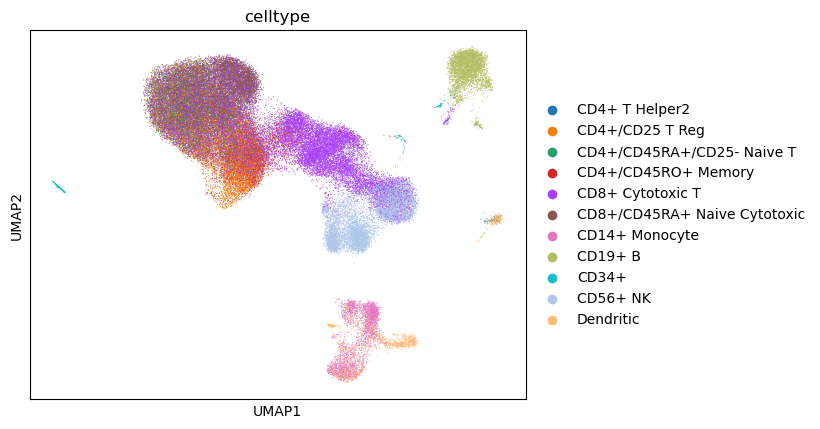

In [21]:
# Get UMAP embedding
query_adata_sym_copy = copy.deepcopy(query_adata_sym)
print(query_adata_sym_copy.shape)

# Normalization
sc.pp.normalize_total(query_adata_sym_copy, target_sum=None)
sc.pp.log1p(query_adata_sym_copy)

# HVG2000
sc.pp.highly_variable_genes(query_adata_sym_copy, n_top_genes=2000)
# filtering HVG2000
query_adata_sym_copy = query_adata_sym_copy[:, query_adata_sym_copy.var.highly_variable]
print(query_adata_sym_copy.shape)

# PCA
sc.tl.pca(query_adata_sym_copy, svd_solver='arpack')

# Neighboring graph
sc.pp.neighbors(query_adata_sym_copy, n_neighbors=10, n_pcs=50)
sc.tl.umap(query_adata_sym_copy)
sc.pl.umap(query_adata_sym_copy, color='celltype')

/var/folders/t1/zclr_f3s57j185f2tblqgwt00000gn/T/ipykernel_97628/1356671569.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(query_adata_sym_copy, resolution=0.9)


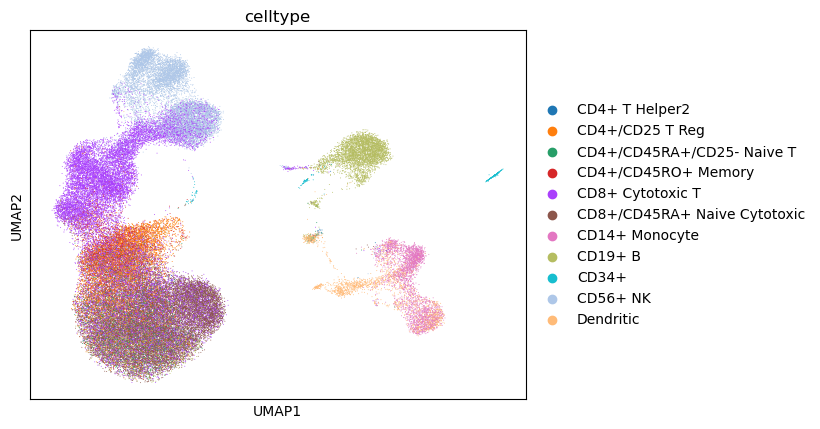

In [22]:
# Leiden and PAGA
sc.tl.leiden(query_adata_sym_copy, resolution=0.9)
sc.tl.paga(query_adata_sym_copy)
sc.pl.paga(query_adata_sym_copy, plot=False)
sc.tl.umap(query_adata_sym_copy, init_pos='paga')
sc.pl.umap(query_adata_sym_copy, color='celltype')

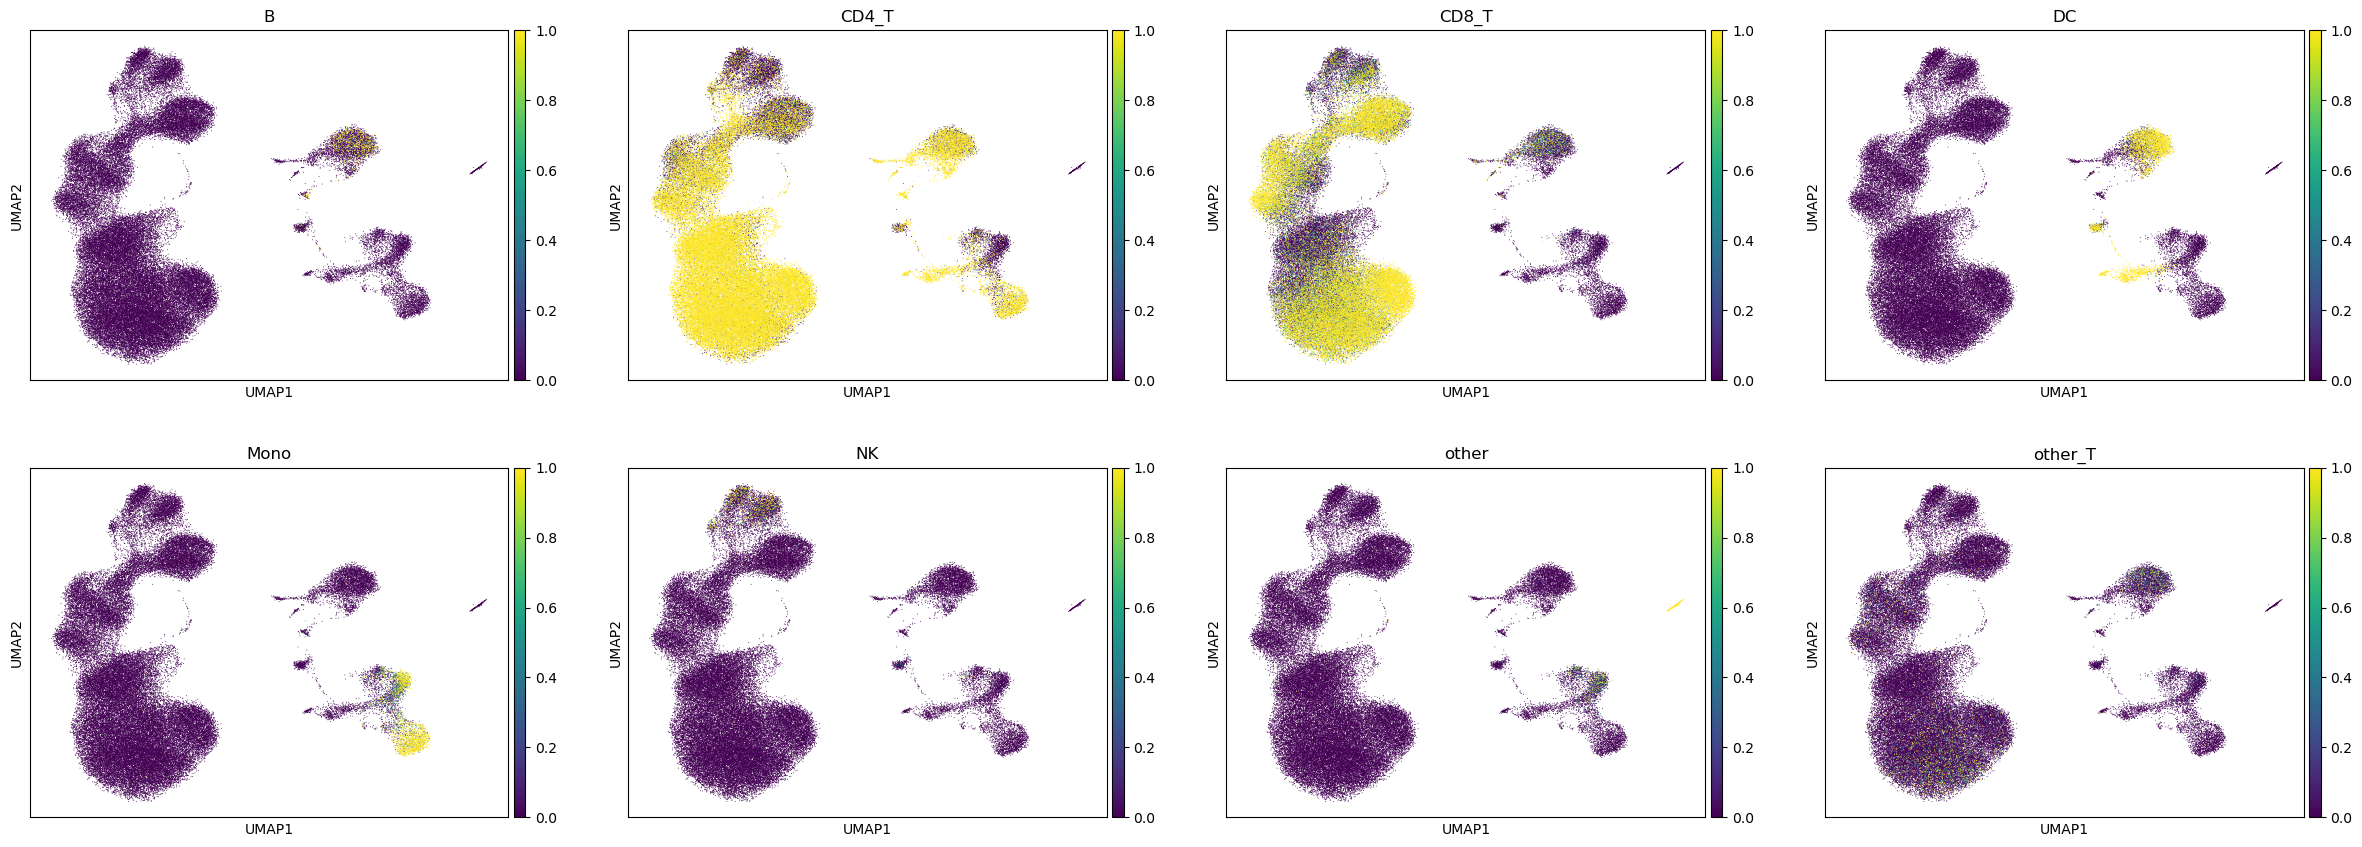

In [23]:
sc.pl.umap(query_adata_sym_copy, color=types)

## Plot likelihood on tSNE

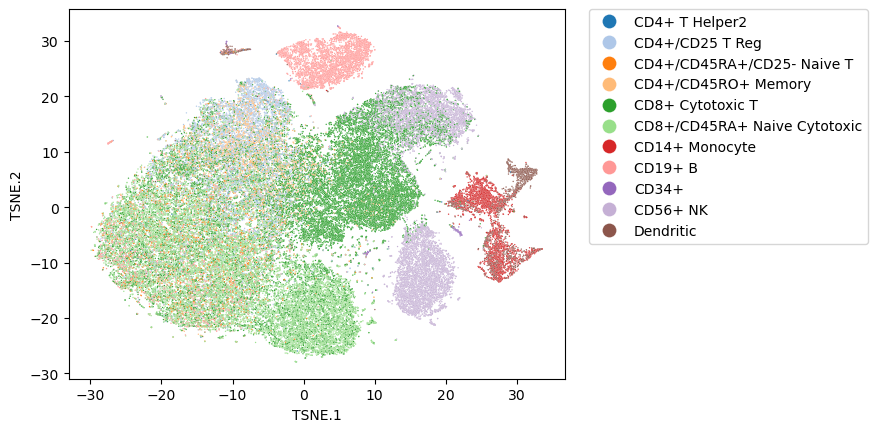

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

obs = query_adata_sym.obs
# Create the scatter plot
ax = sns.scatterplot(x='TSNE.1', y='TSNE.2', hue='celltype', data=obs, s=1, legend="full", palette='tab20')

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)
# plt.legend(handles, labels)

plt.show()

In [26]:
tsne_embedding = obs[['TSNE.1', 'TSNE.2']]
tsne_embedding.head()

TSNE.1     TSNE.2
AAACATACACCCAA-1   7.565540   0.441370
AAACATACCCCTCA-1   2.552626 -25.786672
AAACATACCGGAGA-1  -5.771831  11.830846
AAACATACTAACCG-1   1.762556  25.979346
AAACATACTCTTCA-1 -16.793856 -16.589970

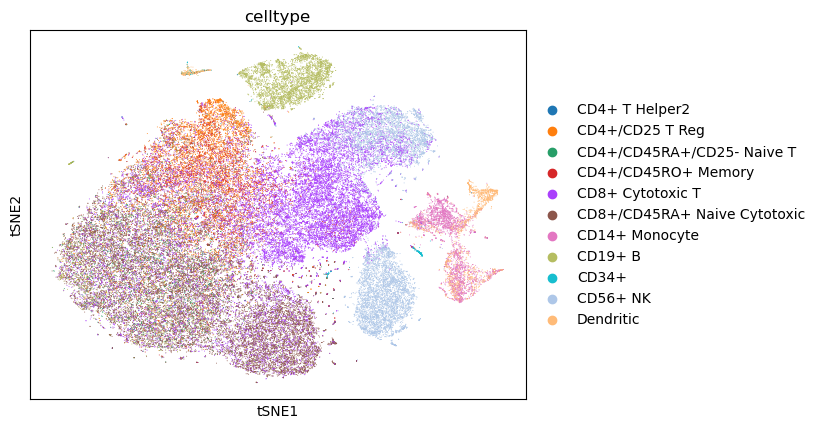

In [28]:
# store the tsne embedding in adata
query_adata_sym_copy.obsm['X_tsne'] = tsne_embedding.values
sc.pl.tsne(query_adata_sym_copy, color='celltype')

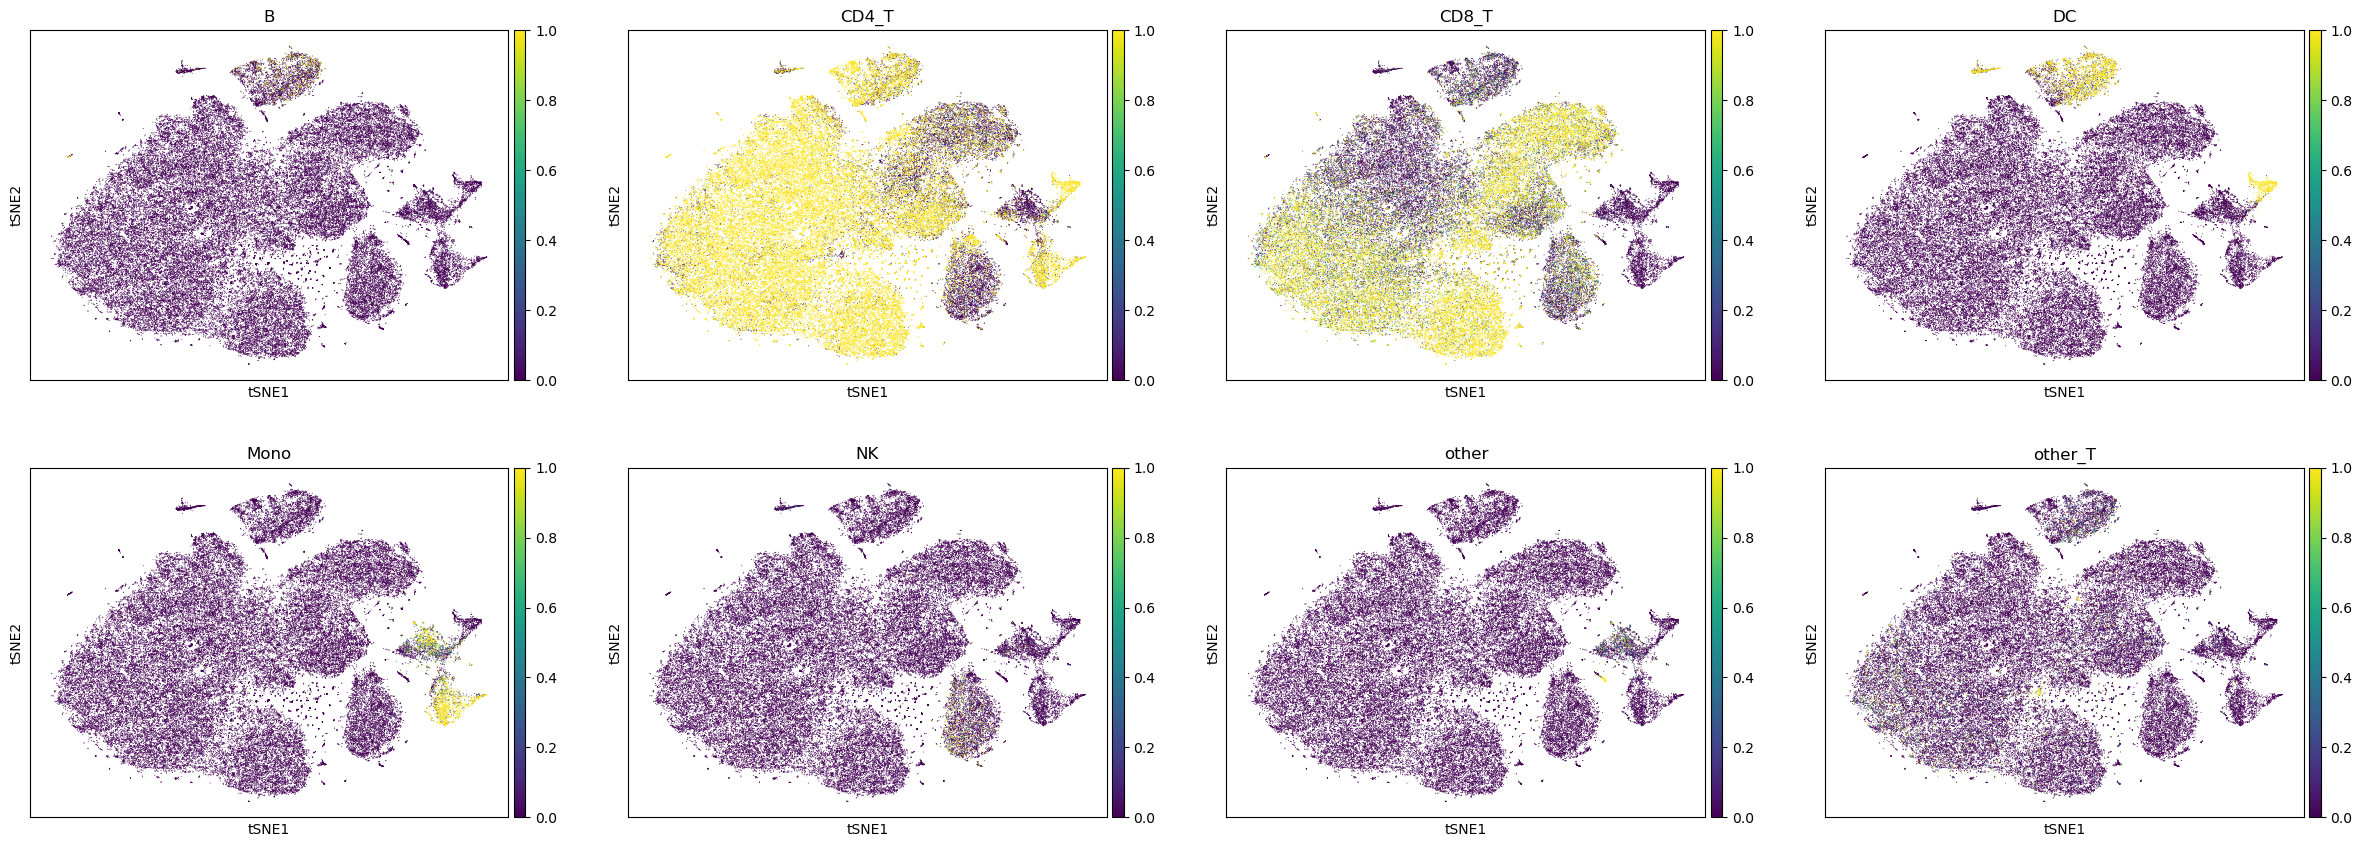

In [29]:
sc.pl.tsne(query_adata_sym_copy, color=types)